In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

#1. Загрузка набора данных

Установим путь к основным каталогам проекта.

In [18]:
from google.colab import drive

In [20]:
dataset='/content/drive/MyDrive/Vegetable Detection with Tensorflow/VegetableImages'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

*определение* количества фотографий в папке.(тестовый набор)

In [21]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))

count_files(os.path.join(test_folder))

There are 200 files in Radish
There are 200 files in Cabbage
There are 200 files in Capsicum
There are 200 files in Pumpkin
There are 200 files in Potato
There are 200 files in Brinjal
There are 200 files in Cucumber
There are 200 files in Cauliflower
There are 200 files in Bean
There are 200 files in Broccoli
There are 200 files in Carrot
There are 200 files in Bottle_Gourd
There are 200 files in Tomato
There are 200 files in Bitter_Gourd
There are 210 files in Papaya


Как видно, набор данных распределен равномерно, каждый класс включает:

В качестве обучающего набора используются 1000 фотографий.

для тестового набора 200 картинок.

#2. Обработка изображений

Улучшение графической информации для человеческого понимания является целью обработки изображений. Более глубокое понимание основных манипуляций и фильтрации также может улучшить извлечение признаков.

Здесь мы можем выбрать любой овощ по нашему выбору, и проводится сравнение необработанной фотографии и случайного изображения из класса.

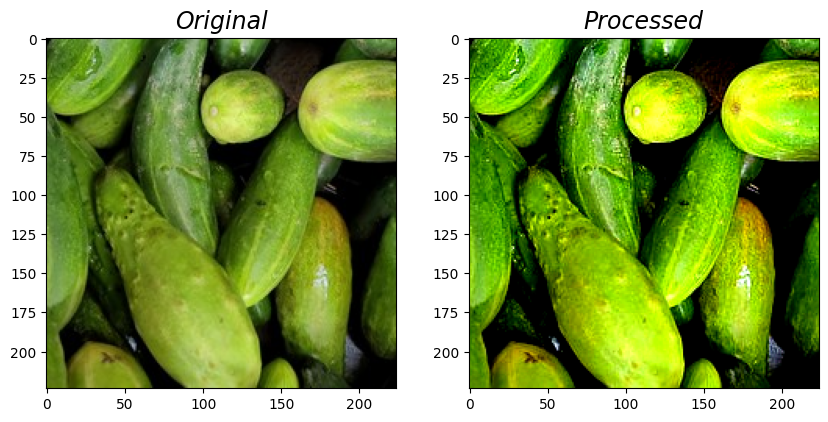

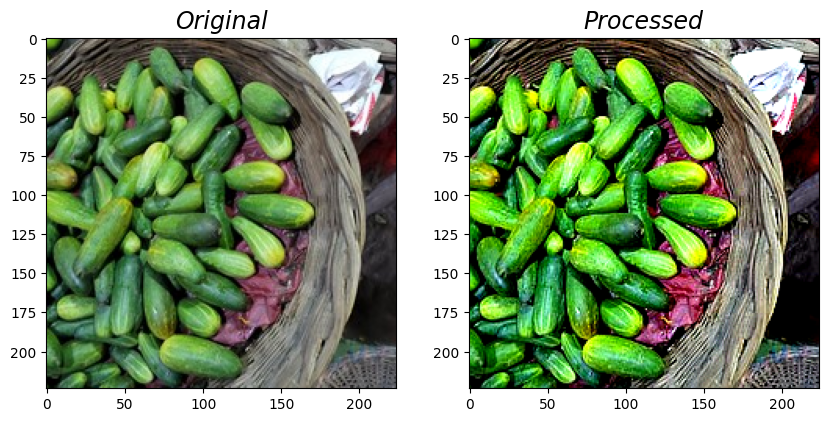

In [22]:
image_folder="Cucumber"
number_of_images=2

def Preprocess():
    j = 1
    for i in range(number_of_images):
        folder = os.path.join(test_folder, image_folder)
        files = os.listdir(folder)

        if not files:
            print(f"Error: No files found in {folder}")
            return

        a = random.choice(files)

        image = Image.open(os.path.join(folder, a))
        image_duplicate = image.copy()
        plt.figure(figsize=(10, 10))

        plt.subplot(number_of_images, 2, j)
        plt.title(label='Original', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j += 1

        image1 = ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1 = ImageEnhance.Contrast(image1).enhance(1.45)
        image1 = ImageEnhance.Sharpness(image1).enhance(2.5)

        plt.subplot(number_of_images, 2, j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j += 1

Preprocess()


Чтобы привлечь внимание зрителя, мы увеличили насыщенность и контрастность цвета, а затем увеличили резкость изображения. После обработки картинка становится привлекательнее и ярче.

#3. Визуализация данных (EDA)
Важным элементом процесса анализа данных является визуализация данных, обычно называемая исследовательским анализом данных (EDA). Чтобы визуально понять закономерности, тенденции и отношения внутри набора данных, необходимо построить графическое представление данных. Прежде чем приступить к более сложному анализу или моделированию, основная цель EDA — получить представление, выявить тенденции и найти возможные проблемы или интригующие аспекты в данных.

Любую метку класса (например, «стручковый перец») можно увидеть, когда мы начинаем исследовать набор данных. Любой овощ можно использовать для визуализации визуальных эффектов этого класса. Кроме того, изменение переменных строк и столбцов влияет на расположение Matplotlib в формате.

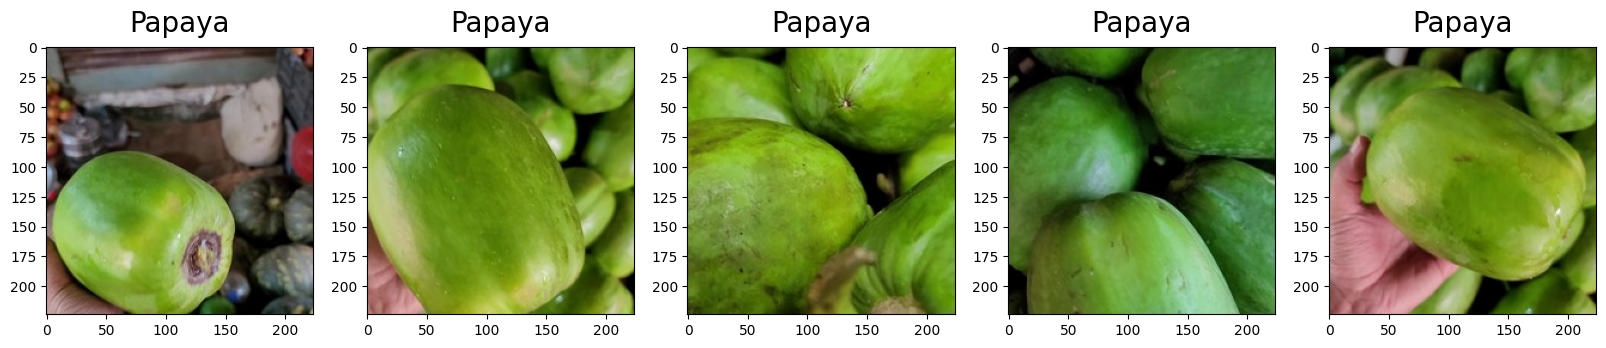

In [23]:
select_vegetable="Papaya"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):

    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)

    if i==total_images-1:
        break

Выбрав случайное изображение из каждого класса в наборе обучающих данных, давайте теперь отобразим весь набор данных.




In [24]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(os.path.join(train_folder, food_folder))

    if food_items:
        food_selected = np.random.choice(food_items)
        images.append(os.path.join(train_folder, food_folder, food_selected))

fig = plt.figure(1, figsize=(15, 10))

for subplot, image_ in enumerate(images):
    category = image_.split('/')[-2]
    imgs = plt.imread(image_)
    a, b, c = imgs.shape
    fig = plt.subplot(3, 5, subplot + 1)
    fig.set_title(category, pad=10, size=18)
    plt.imshow(imgs)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Существует 15 различных типов овощей (выходных классов), и одно случайно выбранное изображение из каждого класса используется для оценки общей структуры набора данных, видимости различных показателей и качества изображения. До сих пор все хорошо!

#4. Построение модели

Давайте начнем создавать сеть трансферного обучения для обучения InceptionV3 нашей модели.

In [25]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

#5. Обучение модели

In [26]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

Found 15000 images belonging to 15 classes.
Found 3010 images belonging to 15 classes.


In [27]:
class_map = training_set.class_indices
class_map

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

#Сохранение обученной модели

In [ ]:
model.save('model_inceptionV3_epoch5.h5')

#Кривые точности и потерь

In [ ]:
def plot_accuracy(history):

    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):

    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

plot_accuracy(r)
plot_loss(r)

#Слои модели

In [30]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]:
    layer_names.append(layer.name)

print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])

Total layers in the model :  315 

First layer :  input_1
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d', 'dense', 'dropout']
Final Layer :  dense_1


#6. Прогнозы

Загрузка обученной модели

In [ ]:
K.clear_session()
path_to_model='/content/drive/MyDrive/model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

#Тестирование модели на проверочном наборе

In [ ]:
validation_data_dir = '/content/drive/MyDrive/Vegetable_Images/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

#функции для прогнозирования результатов нашей модели

In [ ]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1

    true=filedir.split('/')[-1]

    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))

    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

#Прогнозирование одного изображения

In [ ]:
predict_image(os.path.join(validation_folder,'Cauliflower/1064.jpg'),model)

#Прогноз точности каталога проверки

In [ ]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

#7. Оценка

In [ ]:
from google.colab import drive
drive.mount('/content/drive/Vegetable-Detection-with-Tensorflow-learning-PYTHON/Vegetable Images')

#Матрица ошибок для оценки эффективности нашей модели классификации.

In [ ]:
def labels_confusion_matrix(validation_folder):

    folder_path=validation_folder

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

#Отображение каждого ложного изображения, которое наш классификатор предсказал для определенной группы овощей

In [ ]:
def wrong_input_capture(test_category):

    a=os.path.basename(test_category)
    wrong_array=[]

    for i in os.listdir(test_category):

        imggg=os.path.join(test_category,i)

        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)

        index = np.argmax(prediction)
        pred=category.get(index)

        if not pred==a:
            wrong_array.append((imggg,pred))

    return wrong_array

def visualize_wrong_input(images):

    fig=plt.figure(1, figsize=(20, 25))
    total_images=len(images)
    rows=math.ceil(float(total_images/3))
    for subplot,(image_path,predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig=plt.subplot(rows, 3, subplot+1)
        fig.set_title("Predicted - {}".format(predicted), pad = 10,size=18)
        plt.imshow(img)

    plt.tight_layout()

In [ ]:
vegetable="Broccoli"
path=os.path.join(validation_folder,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)